# Выделение главных компонент
Будем работать с данными о состоянии общества в РФ в различные моменты времени

In [7]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import eig
data = pd.read_table("ost_life.csv", index_col=0, decimal=",", sep=";", usecols=range(12))
data.describe()

,прод.ж.,чиновн,браки,разводы,доходы_бедн,дох_богат,самоуб,импорт,авт,нац.богат,водка
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,67.800000,1540.571429,9.142857,3.800000,8.414286,37.857143,58027.142857,54.957143,52.771429,2371.714286,27.542857
std,1.640122,625.711024,1.979779,0.519615,1.924776,6.477617,19075.993005,31.056822,42.201332,1182.736335,6.335050
min,64.600000,1060.000000,5.800000,3.000000,5.500000,32.700000,39150.000000,21.000000,5.500000,689.000000,18.000000
25%,67.300000,1124.000000,8.100000,3.500000,7.000000,33.600000,46378.500000,35.550000,22.750000,1771.500000,24.400000
50%,68.100000,1204.000000,9.700000,3.800000,9.500000,34.000000,58027.000000,45.400000,44.500000,2372.000000,28.000000
75%,69.050000,1747.500000,10.600000,4.150000,9.900000,41.850000,59490.000000,69.100000,75.950000,2934.000000,29.800000
max,69.200000,2777.000000,11.100000,4.500000,10.100000,47.400000,97276.000000,109.000000,122.000000,4130.000000,38.400000


Здесь $n=7$ наблюдений $k=11$ переменных. Сократим их количество до $m=3$ с минимальной возможной потерей данных.
Для начала отцентрируем признаки и построим их ковариационную матрицу.

In [8]:
data -= data.mean()
sigma = np.cov(data, rowvar=False)

Главные компоненты в данных выделяются с использованием собственных чисел и матрицы собственных векторов матрицы $\Sigma$. Найдём эти собственные числа и собственные вектора:

In [9]:
eigvals, eigvectors = eig(sigma) 
# eig returns sorted eigenvalues and array of corresponding eigenvectors
# eigen vectors are on the vertical, i.e. 
# sigma.dot(eigvectors.T[i]) = eigvals[i]*eigvectors[i]

Обозначив собственный вектор собственного числа $\lambda_j$ как $A_j = \left(\begin{array}{c}a_{1j} \\ \vdots \\ a_{kj}\end{array}\right)$, $i$-ю переменную исходных данных -- $X_i$, определим $j$-ю главную компоненту как $$Y_j = \sum_{i=1}^k a_{ij}X_i = A_j^T X_j$$

In [10]:
principal_components = eigvectors.T.dot(data.T) 
# here we have components in rows, 11 rows x 7 columns total

В силу определения главных компонент исходные данных однозначно восстанавливаются по главным компонентам: полагая $A = \left[A_1 \cdots A_k\right]$, имеем $$Y = A^T X \implies X = AY \implies X_i = \sum_{j=1}^k \alpha_{ij}Y_j$$

Для каждого признака и каждой главной компоненты определено понятие факторной нагрузки компоненты на признак $$\beta_{ij} = cor(X_i, Y_j) = {EX_iY_j \over DX_i DY_j} = {EX_iY_j \over DX_i \cdot\lambda_j} = {\sum_{t=1}^k\alpha_{it}Y_tY_j \over \sqrt{DX_i \cdot\lambda_j}} = {\alpha_{ij}\lambda_j \over \sqrt{DX_i \cdot\lambda_j}} = {\alpha_{ij}\sqrt{\lambda_j} \over \sqrt{DX_i}}$$.

Теперь мы можем явно выразить коэффициенты $\alpha_{ij}$:
$$X_i = \sum_{j=1}^k \alpha_{ij}Y_j = \sum_{j=1}^k {\alpha_{it}\sqrt{\lambda_i} \over \sqrt{DX_i}}{\sqrt{DX_i} \over \sqrt{\lambda_i}} \cdot Y_j = \sqrt{DX_i} \sum_{j=1}^k {\beta_{ij} \over \sqrt{\lambda_i}} Y_j = \sum_{j=1}^k {\sqrt{DX_i} EX_iY_j \over \sqrt{DX_i} \lambda_j} Y_j = \sum_{j=1}^k {EX_iY_j \over \lambda_j} Y_j$$

Посмотрим, насколько хорошо данные восстанавливаются по первым трём главным компонентам.

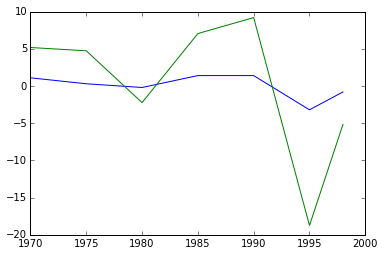

In [12]:
%matplotlib inline
# data: variables in columns, observations in rows
# principal_components: components in columns, "observations" in rows
def recover(data, principal_components, eigenvalues=None):
    n = len(data)
    k = len(data.T)
    # haven't found an appropriate correlation method
    EXY = np.array(map(lambda f:
                       map(lambda d:
                           np.correlate(d, f),
                           data.T), # for variable in data
                       principal_components.T) # for component in components
                  ).reshape((k, k))
    EXY = np.real_if_close(EXY)
    if eigenvalues is None:
        eivenvalues = principal_components.var(axis=0)
    coef = (EXY.T / eigenvalues).T
    return coef
rcoef = recover(data.as_matrix(), principal_components.T, eigvals)
plt.plot(data.index, data["прод.ж."])
plt.plot(data.index, principal_components[:3].T.dot(rcoef[:3])[:,0])